## Concise: 1: Start and mesh
Author: yanjun zhang, Source from book "Abali - 2017 - Computational Reality" P119

DOLFINx version: 0.8.0
DOLFINx version: 0.8.0
Simulation environment setup complete.
Simulation environment setup complete.
1: Total braking tims is  49.89 s
2: Total numb steps is  608
The file 'm-3-5.msh' exists, start creat now:
Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57455 nodes
Info    : 271817 elements
Info    : Done reading 'm-3-5.msh'                                                                               

Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57455 nodes
Info    : 271817 elements
Info    : Done reading 'm-3-5.msh'                                                                               
Volume:, Tag:31
Volume:, Tag:32
Info    : Meshing 1D...
Info    : Done meshing 1D (Wall 2.7622e-05s, CPU 4.3e-05s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 3.9084e-05s, CPU 6e-05s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 0.714559s, CPU 0.715337s)
Info    : Optimizing mesh...
Info    : Done optimizin

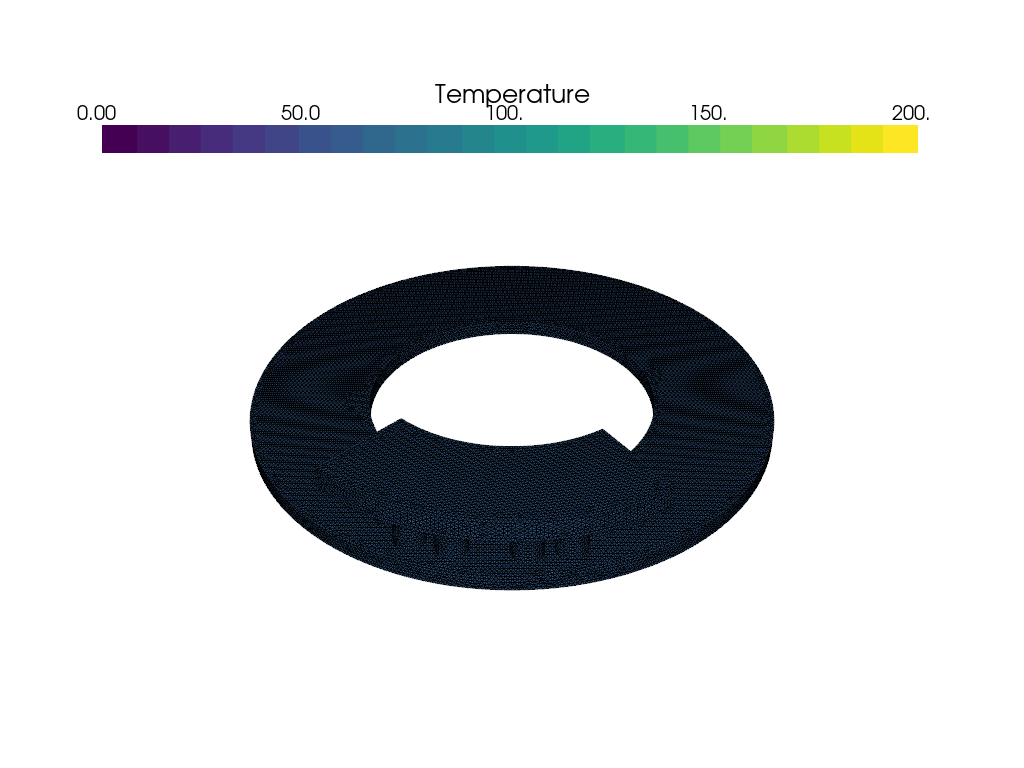

In [1]:
from disc_f1 import *

# mesh-size, contact area coefficient
mesh_min, mesh_max = 3, 5
c_contact          = 1
# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r          = 224
v_vehicle, c_acc   = 160, 1
z1,z2,z3,z4,z_all  = 20,33,30,83,8
pad_v_tag          = 32
# calling local functions to get all parameters
(dt, P, g, num_steps, h, radiation, v_angular, Ti, Tm, S_rub_circle_ini, t, rho, c, k, t_brake, 
S_total,) = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)
print("1: Total braking tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)

## here use lots of abbreviation, details are in disc_f
domain, cell_markers, facet_markers, mesh_name, mesh_name1, mesh_name2 \
                       = mesh_brake_all(mesh_min,mesh_max,pad_v_tag)

V, T_init, u_n         = initial_u_n(domain, Ti)

fdim, bc, mesh_brake, all_e,xdmf, x_co, y_co, ds, b_con \
                       = mesh_setup(domain, V,mesh_name1,num_steps, \
                         angular_r, mesh_name2, c_contact,z_all,Tm, S_rub_circle_ini)
# Initialize
problem,u,v,f,n_vector = variation_initial(V, T_init,domain, rho, c, b_con,\
                          radiation, h, k, xdmf,dt,ds,u_n, Tm,g,bc);
n,converged = solver_setup_solve(problem,u)

## Visualization of time dependent problem using pyvista
gif_name    = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(num_steps, angular_r, mesh_name2, c_contact, all_e)
plotter, sargs, renderer, warped, viridis, grid = plot_gif(V,u,gif_name)
##solve
num_steps= int(num_steps/10/6)




#####################################################

def solve_heat(Ti, u, num_steps, dt, x_co, y_co, angular_r, \
               t_brake, domain, S_rub_circle, fdim,\
               rho, c, v, radiation, k, h, f, Tm, u_n, g,\
               ds, xdmf, b_con, bc, plotter, warped,\
               mesh_name1, mesh_brake, pad_v_tag, z4,\
               z1, x_co_zone,  ):
    
    T_array = [(0, [Ti for _ in range(len(u.x.array))])]
    total_degree = 0
    t = 0
    fraction_c = []
    for i in range(num_steps):
        t += dt[i]

        ##################################3
        u_d0, Vu, aM, LM, bcu, u_, domain_pad   = T_S_deformation_solve (mesh_name1, u_n, mesh_brake, pad_v_tag, z4, )
        u_d1 = penalty_method_contact(z1, Vu, u_d0, aM, LM, u_, bcu  )
        
        deformed_co, new_c = get_new_contact_nodes(x_co_zone, domain_pad, u_d1, Vu, z1, x_co, y_co )
        x_co_new, y_co_new, r_rub_new, S_total_new,S_rub_circle_new = get_r_xco_yco (deformed_co, new_c )
        S_rub_circle = S_rub_circle_new
        fraction_c.append(  S_total_new/ 200 )
        #####################################

        x_co, y_co = rub_rotation(x_co_new, y_co_new, angular_r)  # update the location
        total_degree += angular_r  # Incrementing degree by 10 in each step
        # Construct the message     

        end_time = time.time()
        elapsed_time = end_time - start_time
        elapsed_time1 = round(elapsed_time, 0)
        formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
        if elapsed_time1 >= 60:
           min = elapsed_time1 / 60
           hours = min / 60
           progress_message = f"1: Progress: {round(100 * (t / t_brake), 1)}%. Use time: {round(hours)} hours {round(min)} min. Start: {formatted_start_time }."
        else:
           progress_message = f"1: Progress: {round(100 * (t / t_brake), 1)}%. Use time: {round(elapsed_time1)} s. Start: {formatted_start_time }."
    
        sys.stdout.write(f"\r{progress_message.ljust(80)}")  # 80 spaces to ensure full clearing
        sys.stdout.flush()
        

        #####################################
        #co_ind, fa_mar, so_ind = target_facets(domain, x_co, y_co, S_rub_circle )
        co_ind, fa_mar, so_ind   = target_facets(domain, x_co, y_co, S_rub_circle )
        facet_tag                = meshtags( domain, fdim, co_ind[so_ind], fa_mar[so_ind] )
        ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

        F = ((rho * c) / dt[i] * inner(u, v) * dx
            + k * inner(grad(u), grad(v)) * dx
            + h * inner(u, v) * ds(b_con)
            + radiation * inner(u**4, v) * ds(b_con)
            - ( inner(f, v) * dx
                + (rho * c) / dt[i] * inner(u_n, v) * dx
                + h * Tm * v * ds(b_con)
                + radiation * (Tm**4) * v * ds(b_con)) )

        for j in list(range(1, 19)):
            #F += -k * dot(grad(u) * v, n_vector) * ds(10 * j) - inner(g[i], v) * ds(10 * j)
            F += ( - inner(g[i], v) * ds(10 * j) 
                   - h * inner( u, v) * ds(10 * j)  
                   - radiation * inner( (u**4 - Tm**4), v) * ds(10 * j) )    

        problem = NonlinearProblem(F, u, bcs=[bc])

        ## 7: Using petsc4py to create a linear solver
        solver_setup_solve(problem,u)
        u.x.scatter_forward()
  
        # Update solution at previous time step (u_n)
        u_n.x.array[:] = u.x.array
        T_array.append((t, u.x.array.copy()))
        # Write solution to file
        xdmf.write_function(u, t)
        # Update plot
        #warped = grid.warp_by_scalar("uh", factor=0)
        plotter.update_coordinates(warped.points.copy(), render=False)
        plotter.update_scalars(u.x.array, render=False)
        plotter.write_frame()

    plotter.close()
    xdmf.close()
    print()
    return(T_array, fraction_c)
###################################################################
x_co_zone   = 0.002

T_array,fraction_c = solve_heat(Ti, u, num_steps, dt, x_co, y_co, angular_r, \
               t_brake, domain, S_rub_circle_ini, fdim,\
               rho, c, v, radiation, k, h, f, Tm, u_n, g,\
               ds, xdmf, b_con, bc, plotter, warped,\
               mesh_name1, mesh_brake, pad_v_tag, z4,\
               z1, x_co_zone, )
####################################################################


csv_name    = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(num_steps, angular_r, mesh_name2, c_contact, all_e  )
# got the Temperature data
save_t_T(csv_name, T_array)

from IPython.display import display, Image
display(Image(gif_name))

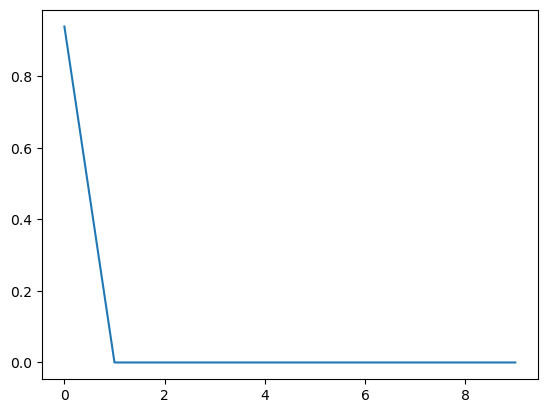

In [2]:
plt.plot(fraction_c)

# 2: New brake pad points, add boundary for rubbing elements

Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57455 nodes
Info    : 271817 elements
Info    : Done reading 'm-3-5.msh'                                                                               
Volume:, Tag:31
Volume:, Tag:32
Info    : Meshing 1D...
Info    : Done meshing 1D (Wall 2.636e-05s, CPU 6e-05s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 3.195e-05s, CPU 5.3e-05s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 0.602088s, CPU 0.602861s)
Info    : Optimizing mesh...
Info    : Done optimizing mesh (Wall 0.00977301s, CPU 0.009583s)
Info    : 57455 nodes 271865 elements
Info    : Writing 'new_pad.msh'...
Info    : Done writing 'new_pad.msh'
Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57455 nodes
Info    : 271817 elements
Info    : Done reading 'm-3-5.msh'                                                                               
Info    : Reading 'new_pad.msh'...
Info    : 168 entities
Info    : 17025 nodes
Info

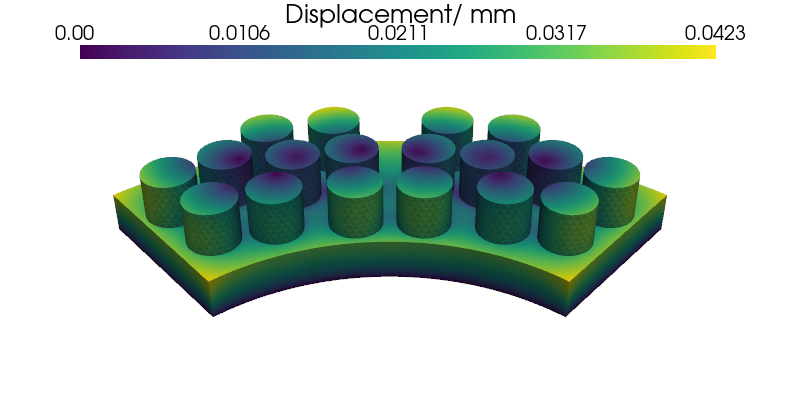

In [2]:
u_d, Vu, aM, LM, bcu, u_,  domain_pad   = T_S_deformation_solve (mesh_name1, u_n, mesh_brake, pad_v_tag, z4, )
u_d = penalty_method_contact(z1, Vu, u_d, aM, LM, u_, bcu  )
x_co_zone   = 0.002
deformed_co, new_c = get_new_contact_nodes(x_co_zone, domain_pad, u_d,  Vu, z1, x_co, y_co )
x_co_new, y_co_new, r_rub_new, S_total_new,S_rub_circle_new = get_r_xco_yco (deformed_co, new_c )
fraction_c = S_total_new/ 200


print('Total contact surface is: ', round(S_total_new, 2), " mm")
print(f"Contact friction is {fraction_c:.2f}")


scale_factor = 1
plot_s_pad = plot_S_pad(Vu, u_d, scale_factor)
plot_s_pad.show()

vtk = io.VTKFile(domain_pad.comm, "pad_deformation", "w")
vtk.write_function(u_d)
vtk.close()

## 1: Visualizing the displacement profile in the z-direction
plt.plot(u_d.x.array[2::3])
plt.title("Displacement in z-direction")
plt.xlabel("Node Index")
plt.ylabel("Displacement (z-direction)")
plt.grid()
plt.show()

Identify contact areas and plot them
contact_nodes = np.where(u_d.x.array[2::3] >= z1)[0]  # Nodes in contact with the surface at z1
contact_coordinates = pad_node_coordinates[contact_nodes]  # Get the coordinates of contact nodes

Plotting contact nodes
plt.scatter(contact_coordinates[:, 0], contact_coordinates[:, 1], label="Contact Nodes", c='red', s=10)
plt.title("Contact Area on Brake Pad")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid()
plt.legend()
plt.show()

## 2: Cut the nodes below the z1, but this method is not perfect since only x[2]=z1 in the begin are cuted.

def bottom_contact_nodes(x):
    return np.isclose(x[2], z1)
contact_dofs = fem.locate_dofs_geometrical(Vu, bottom_contact_nodes)
u_d = fem.Function(Vu, name="Displacement")
problem = fem.petsc.LinearProblem(aM, LM, u=u_d, bcs=bcu)
problem.solve()
u_vals = u_d.x.array.reshape(-1, gdim)   # Get displacement values
for dof in contact_dofs:
    if u_vals[dof][2] < z1:
        u_vals[dof][2] = 0  # Set minimum z value to z1
u_d.x.array[:] = u_vals.ravel()
scale_factor = 1
plot_s_pad = plot_S_pad(Vu, u_d, scale_factor)
plot_s_pad.show()

## 3: Relationship between penalty stiffness and the maximum penatration.

n = 4
deform_max=[]
for i in range(n):

  penalty_param = 400+i*10
  u_d = fem.Function(Vu, name="Displacement")
  problem = fem.petsc.LinearProblem(aM, LM, u=u_d, bcs=bcu)
  problem.solve()
  update_penalty_force(u_d, penalty_forces, z1, penalty_param)
    # Define the modified right-hand side with penalty forces included
  u_d = fem.Function(Vu, name="Displacement")
  LM_penalized = LM + ufl.inner(penalty_forces, u_) * ufl.dx
    # Re-solve with updated forces
  problem = fem.petsc.LinearProblem(aM, LM_penalized, u=u_d, bcs=bcu)
  problem.solve()
  u_d_vals = u_d.x.array.reshape(-1, gdim)  
  
  original_coordinates = domain_pad.geometry.x  # Initial coordinates of nodes (N x 3 array)
  u_d_vals = u_d.x.array.reshape(-1, gdim)  # Displacements (N x 3 array)
  deformed_coordinates = original_coordinates + u_d_vals  # Element-wise addition
  below_z1_nodes = deformed_coordinates[ deformed_coordinates[:, 2] <= z1]  # Select nodes with z < z1
  close_z1_nodes = deformed_coordinates  [ ( deformed_coordinates[:, 2] < 21) & (deformed_coordinates[:, 2] > 19) ] 
  deform_max.append(min( below_z1_nodes[:,2]))
c = list( range(1,n+1))
plt.plot(c, deform_max)


## 4: Get facet nodes connection
target_tag = 18  # Replace with the actual tag of interest

nodes = domain_pad.geometry.x

facet_dim = domain_pad.topology.dim - 1  # For 3D, facet_dim is 2
domain_pad.topology.create_connectivity(facet_dim, 0)  # Facet to vertex connectivity
facet_to_vertex = domain_pad.topology.connectivity(facet_dim, 0)

i=0

for facet_index in range(len(facet_mark_pad.values)):

    if facet_mark_pad.values[facet_index] == target_tag:
      
        node_indices = facet_to_vertex.links(facet_index)      
      
        facet_nodes = nodes[node_indices]    
        i = i+1
        
        print(f"Facet {facet_index} with tag {target_tag} has nodes {node_indices}")


## 5: Another way to found the contact nodes for original mesh
len_dofs = 0
for j in range(18):
    marker = (j + 1) * 10
    locator_func1 = lambda x, j=j: (x[0] - x_co[j])**2 + (x[1] - y_co[j])**2 <= S_rub_circle  
    dofs1 = fem.locate_dofs_geometrical(Vu, locator_func1)
    locator_func2 = lambda x : np.isclose(x[2],z1) 
    # np.isclose is betwen than x[2]=z1, since it accounting for potential floating error,
    # for x[2]=z1, it have exactly number for this, for mesh, it generate error.
    dofs2 = fem.locate_dofs_geometrical(Vu, locator_func2)
    dofs3 = np.intersect1d(dofs1, dofs2)
    len_dofs = len_dofs+ len(dofs3)   
    #boundary_dofs.append((marker, dofs3))
    boundary_dofs.append(dofs3)
dof_coordinates = Vu.tabulate_dof_coordinates().reshape(-1, 3)  # Auto-detect dimensions
!# Extract nodes corresponding to these dofs for each boundary marker
dofs4 = []
!#for marker, dofs in boundary_dofs:
for dofs in boundary_dofs:
    boundary_nodes = dof_coordinates[dofs]
    dofs4 = np.hstack( (dofs4, dofs) )
dofs4 = dofs4.astype(int)    
!#dofs4 = np.sort(dofs4)
    
print ('1: Len of boundary nodes ', len(boundary_nodes)  ) 
print('2: Len of dof coordinates ',len(dof_coordinates))
print('3: Len of contact nodes ', len(dofs4))

print(boundary_dofs[17])

## 6: Compare the length for old and new contact
this loop is used to get the length of the rub contact nodes
facet_1 = []
rub_c_nodes = []
for i in range(18):
    define_i = lambda x: (x[0]-x_co[i])**2 + (x[1]-y_co[i])**2 <= S_rub_circle 
    dofs1 = fem.locate_dofs_geometrical(Vu, define_i)
    # np.isclose is betwen than x[2]=z1, since it accounting for potential floating error,
    # for x[2]=z1, it have exactly number for this, for mesh, it generate error.
    define_contact_s = lambda x: np.isclose(x[2],z1)
    dofs2 = fem.locate_dofs_geometrical(Vu, define_contact_s)
    dofs3 = np.intersect1d(dofs1, dofs2)
    dofs3 = dofs3.astype(int)
    rub_c_nodes = rub_c_nodes+ [dofs3]


length_c_nodes = 0
for i in range( len( rub_c_nodes)):
    length_c_nodes += len( rub_c_nodes[i])
print('1: Old contact nodes number is ',length_c_nodes)
n_contact_new = sum( len(item) for item in new_c)
print("2: New contact nodes number is ", n_contact_new)

old_c_nodes = rub_c_nodes 